In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile

In [3]:
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [8]:
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

In [9]:
dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=cache_dir,
    extract=True,
    archive_format='zip'
)

53362688/53355492 [==============================] - 0s 0us/step


In [10]:
!ls -la ./tmp/datasets/

total 251968
drwxr-xr-x 2 root root     4096 Nov 26 10:09 .
drwxr-xr-x 3 root root     4096 Nov 26 10:08 ..
-rw-r--r-- 1 root root    20437 Nov 26 10:09 LICENSE
-rw-r--r-- 1 root root 49784325 Nov 26 10:08 recipes_raw_nosource_ar.json
-rw-r--r-- 1 root root 61133971 Nov 26 10:08 recipes_raw_nosource_epi.json
-rw-r--r-- 1 root root 93702755 Nov 26 10:09 recipes_raw_nosource_fn.json
-rw-r--r-- 1 root root 53355492 Nov 26 10:08 recipes_raw.zip


In [12]:
def load_dataset(silent=False):
  dataset_file_names = [
      'recipes_raw_nosource_ar.json',
      'recipes_raw_nosource_epi.json',
      'recipes_raw_nosource_fn.json'
  ]

  dataset = []

  for file_name in dataset_file_names:
    file_path = f'{cache_dir}/datasets/{file_name}'

    with open(file_path) as dataset_file:
      json_data_dict = json.load(dataset_file)
      json_data_list = list(json_data_dict.values())   
      dict_keys = [key for key in json_data_list[0]]
      dict_keys.sort()

      dataset += json_data_list

  return dataset   


In [13]:
dataset_raw = load_dataset()

In [14]:
dataset_raw[0]

{'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT',
  '2 tablespoons butter ADVERTISEMENT',
  '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT',
  '1 onion, finely diced ADVERTISEMENT',
  '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT',
  'ADVERTISEMENT'],
 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S',
 'title': 'Slow Cooker Chicken and Dumplings'}

In [15]:
len(dataset_raw)

125164

In [24]:
def recipe_validate_required_fields(recipe):
  required_keys = ['title', 'ingredients', 'instructions']

  if not recipe:
    return False

  for required_key in required_keys:
    if not recipe[required_key]:
      return False

    if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
      return False
      
  return True

In [29]:
valid_datasets = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

In [31]:
len(valid_datasets)

122938

In [32]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [36]:
def recipe_to_str(recipe):
  noize_string = 'ADVERTISEMENT'

  title = recipe['title']
  ingredients = recipe['ingredients']
  instructions = recipe['instructions'].split('\n')

  ingredients_str = ''

  for ing in ingredients:
    ing = ing.replace(noize_string, '')
    if ing:
      ingredients_str += f'* {ing}\n'

  instructions_str = ''

  for inst in instructions:
    inst = inst.replace(noize_string, '')
    if inst:
      instructions_str += f'*{inst}\n'


  return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_str}{STOP_WORD_INSTRUCTIONS}{instructions_str}'



In [37]:
dataset_stringified = [recipe_to_str(recipe) for recipe in valid_datasets]

In [39]:
for recipe_idx, recipe_str in enumerate(dataset_stringified[:10]):
  print('Recipe #{}\n--------'.format(recipe_idx + 1))
  print(recipe_str)
  print('\n')

Recipe #1
--------
📗 Slow Cooker Chicken and Dumplings

🥕

* 4 skinless, boneless chicken breast halves 
* 2 tablespoons butter 
* 2 (10.75 ounce) cans condensed cream of chicken soup 
* 1 onion, finely diced 
* 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

*Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
*Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
--------
📗 Awesome Slow Cooker Pot Roast

🥕

* 2 (10.75 ounce) cans condensed cream of mushroom soup 
* 1 (1 ounce) package dry onion soup mix 
* 1 1/4 cups water 
* 5 1/2 pounds pot roast 

📝

*In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
*Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe #3
-------

In [40]:
recipes_len = []

for recipe_str in dataset_stringified:
  recipes_len.append(len(recipe_str))

(array([  112.,  2728.,  7642., 11217., 13456., 13383., 12101., 10308.,
         8896.,  7581.,  6128.,  4774.,  4070.,  3373.,  2718.,  2252.,
         1781.,  1558.,  1349.,  1091.,   890.,   724.,   647.,   597.,
          458.,   431.,   355.,   289.,   263.,   222.,   204.,   181.,
          147.,   117.,   104.,    87.,    86.,    76.,    48.,    52.,
           49.,    56.,    35.,    33.,    21.,    18.,    20.,    17.,
           20.,    15.]),
 array([   0.,  160.,  320.,  480.,  640.,  800.,  960., 1120., 1280.,
        1440., 1600., 1760., 1920., 2080., 2240., 2400., 2560., 2720.,
        2880., 3040., 3200., 3360., 3520., 3680., 3840., 4000., 4160.,
        4320., 4480., 4640., 4800., 4960., 5120., 5280., 5440., 5600.,
        5760., 5920., 6080., 6240., 6400., 6560., 6720., 6880., 7040.,
        7200., 7360., 7520., 7680., 7840., 8000.]),
 <a list of 50 Patch objects>)

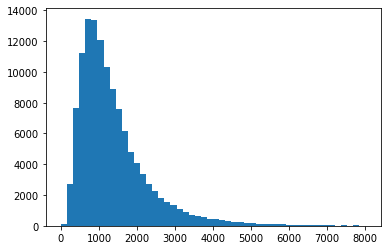

In [44]:
plt.hist(recipes_len, range=(0,8000), bins=50)

In [45]:
MAX_RECIPE_LENGTH = 3000

In [46]:
dataset = list(filter(lambda x: len(x) <= MAX_RECIPE_LENGTH, dataset_stringified))

In [47]:
print(len(dataset))

115128


In [48]:
STOP_SIGN = '␣'

In [50]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [51]:
tokenizer.fit_on_texts([STOP_SIGN])

In [52]:
tokenizer.fit_on_texts(dataset)

In [53]:
tokenizer.get_config()

{'char_level': True,
 'document_count': 115129,
 'filters': '',
 'index_docs': '{"1": 115128, "180": 1, "59": 43923, "7": 115123, "26": 114232, "31": 103724, "41": 80558, "40": 80541, "19": 114618, "5": 115121, "22": 113247, "4": 115121, "34": 93520, "51": 115128, "23": 115079, "10": 115122, "17": 115128, "50": 115128, "37": 93259, "62": 39062, "18": 114891, "35": 97307, "27": 112763, "64": 29059, "3": 115118, "8": 115123, "12": 115077, "38": 78650, "9": 115120, "21": 113440, "56": 50305, "15": 114962, "28": 111298, "6": 115114, "39": 74635, "13": 115106, "11": 115110, "49": 115128, "42": 74024, "20": 115128, "2": 115128, "32": 96978, "14": 115077, "24": 114143, "29": 111638, "16": 114904, "25": 112230, "70": 16872, "30": 103730, "48": 66045, "36": 85202, "58": 45811, "61": 40266, "52": 55447, "43": 76071, "45": 57654, "53": 57948, "47": 69971, "33": 89144, "76": 5968, "57": 48847, "46": 66506, "55": 46078, "71": 12556, "54": 40514, "60": 42587, "66": 22266, "63": 26046, "74": 9912, "4

In [54]:
VOCAB_SIZE = len(tokenizer.word_counts) + 1 

In [55]:
VOCAB_SIZE

190

In [56]:
vocab = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCAB_SIZE)])

In [57]:
tokenizer.texts_to_sequences('📗 ')

[[49], [1]]

In [58]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset)

In [59]:
print(len(dataset_vectorized))

115128


In [60]:
print(dataset_vectorized[0])

[49, 1, 31, 10, 5, 24, 1, 35, 5, 5, 25, 2, 8, 1, 35, 12, 7, 13, 25, 2, 6, 1, 4, 6, 11, 1, 56, 14, 16, 15, 10, 7, 6, 18, 9, 17, 17, 50, 17, 17, 20, 1, 32, 1, 9, 25, 7, 6, 10, 2, 9, 9, 21, 1, 19, 5, 6, 2, 10, 2, 9, 9, 1, 13, 12, 7, 13, 25, 2, 6, 1, 19, 8, 2, 4, 9, 3, 1, 12, 4, 10, 27, 2, 9, 1, 17, 20, 1, 29, 1, 3, 4, 19, 10, 2, 9, 15, 5, 5, 6, 9, 1, 19, 14, 3, 3, 2, 8, 1, 17, 20, 1, 29, 1, 41, 26, 39, 23, 64, 38, 1, 5, 14, 6, 13, 2, 40, 1, 13, 4, 6, 9, 1, 13, 5, 6, 11, 2, 6, 9, 2, 11, 1, 13, 8, 2, 4, 16, 1, 5, 22, 1, 13, 12, 7, 13, 25, 2, 6, 1, 9, 5, 14, 15, 1, 17, 20, 1, 26, 1, 5, 6, 7, 5, 6, 21, 1, 22, 7, 6, 2, 10, 28, 1, 11, 7, 13, 2, 11, 1, 17, 20, 1, 29, 1, 41, 26, 39, 1, 5, 14, 6, 13, 2, 40, 1, 15, 4, 13, 25, 4, 18, 2, 9, 1, 8, 2, 22, 8, 7, 18, 2, 8, 4, 3, 2, 11, 1, 19, 7, 9, 13, 14, 7, 3, 1, 11, 5, 14, 18, 12, 21, 1, 3, 5, 8, 6, 1, 7, 6, 3, 5, 1, 15, 7, 2, 13, 2, 9, 1, 17, 17, 51, 17, 17, 20, 37, 10, 4, 13, 2, 1, 3, 12, 2, 1, 13, 12, 7, 13, 25, 2, 6, 21, 1, 19, 14, 3, 3, 2, 8, 21,

In [63]:
def recipe_sequence_to_str(recipe_seq):
  recipe_str = tokenizer.sequences_to_texts([recipe_seq])[0]
  recipe_str = recipe_str.replace('  ', '_').replace(' ', '').replace('_', ' ')
  print(recipe_str)

In [64]:
recipe_sequence_to_str(dataset_vectorized[0])

📗 Slow Cooker Chicken and Dumplings

🥕

* 4 skinless, boneless chicken breast halves 
* 2 tablespoons butter 
* 2 (10.75 ounce) cans condensed cream of chicken soup 
* 1 onion, finely diced 
* 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

*Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
*Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



In [65]:
for recipe_idx, recipe in enumerate(dataset_vectorized[:10]):
  print('Recipe #{} length: {}'.format(recipe_idx + 1, len(recipe)))

Recipe #1 length: 542
Recipe #2 length: 397
Recipe #3 length: 663
Recipe #4 length: 730
Recipe #5 length: 1508
Recipe #6 length: 734
Recipe #7 length: 2665
Recipe #8 length: 831
Recipe #9 length: 661
Recipe #10 length: 1258


In [66]:
dataset_vectorized_padding_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    maxlen = MAX_RECIPE_LENGTH - 1,
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [67]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padding_without_stops,
    padding='post',
    truncating='post',
    maxlen = MAX_RECIPE_LENGTH + 1,
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [69]:
for recipe_idx, recipe in enumerate(dataset_vectorized_padded[:10]):
  print('Recipe #{} length: {}'.format(recipe_idx + 1, len(recipe)))

Recipe #1 length: 3001
Recipe #2 length: 3001
Recipe #3 length: 3001
Recipe #4 length: 3001
Recipe #5 length: 3001
Recipe #6 length: 3001
Recipe #7 length: 3001
Recipe #8 length: 3001
Recipe #9 length: 3001
Recipe #10 length: 3001


In [70]:
recipe_sequence_to_str(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

* 4 skinless, boneless chicken breast halves 
* 2 tablespoons butter 
* 2 (10.75 ounce) cans condensed cream of chicken soup 
* 1 onion, finely diced 
* 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

*Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
*Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [71]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

In [72]:
dataset

<TensorSliceDataset shapes: (3001,), types: tf.int32>

In [73]:
# Hello
# input Hell
# target ello

def split_input_target(recipe):
  input_text = recipe[:-1]
  target_text = recipe[1:]

  return input_text, target_text

  

In [74]:
dataset_targeted = dataset.map(split_input_target)

In [75]:
dataset_targeted

<MapDataset shapes: ((3000,), (3000,)), types: (tf.int32, tf.int32)>

In [79]:
for input_example, target_example in dataset_targeted.take(1):
  print('input seq size', repr(len(input_example.numpy())))
  print('target seq size', repr(len(target_example.numpy())))
  print()

  input_str = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
  target_str = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]

  print('input: ', repr(''.join(input_str)))
  print('target:', repr(''.join(target_str)))

input seq size 3000
target seq size 3000

input:  '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n *   4   s k i n l e'
target: '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n *   4   s k i n l e s'


In [81]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
  print('step {:2d}'.format(i+1))
  print('input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
  print('expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))


step  1
input: 49 ('📗')
expected output: 1 (' ')
step  2
input: 1 (' ')
expected output: 31 ('S')
step  3
input: 31 ('S')
expected output: 10 ('l')
step  4
input: 10 ('l')
expected output: 5 ('o')
step  5
input: 5 ('o')
expected output: 24 ('w')
step  6
input: 24 ('w')
expected output: 1 (' ')
step  7
input: 1 (' ')
expected output: 35 ('C')
step  8
input: 35 ('C')
expected output: 5 ('o')
step  9
input: 5 ('o')
expected output: 5 ('o')
step 10
input: 5 ('o')
expected output: 25 ('k')


In [82]:
BATCH_SIZE = 64

In [83]:
dataset_train = dataset_targeted \
  .shuffle(1000) \
  .batch(BATCH_SIZE, drop_remainder=True) \
  .repeat()

In [84]:
dataset_train

<RepeatDataset shapes: ((64, 3000), (64, 3000)), types: (tf.int32, tf.int32)>

In [85]:
# 임베딩, LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=256, batch_input_shape=[BATCH_SIZE, None]),
  tf.keras.layers.LSTM(units=1024, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(VOCAB_SIZE)
])

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           48640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 190)           194750    
Total params: 5,490,366
Trainable params: 5,490,366
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.compile(optimizer='adam', loss='sparse_categorical_entropy')

In [89]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [90]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [91]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [92]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints